# Introducción


La monitorización precisa de la presión intracraneal (ICP) es fundamental para el manejo clínico de pacientes con afecciones neurológicas graves, incluidos niños con lesiones cerebrales traumáticas y otras patologías que elevan la ICP (Fanelli et al., 2019). A pesar de la importancia vital de esta práctica, la medición invasiva de la ICP, que sigue siendo el gold standard, presenta riesgos significativos y limitaciones, incluida la variabilidad en su uso y la necesidad de experiencia neuroquirúrgica especializada (Imaduddin et al., 2020). Por otro lado, las técnicas no invasivas existentes, aunque seguras, no han logrado integrarse en la práctica clínica debido a su incapacidad para proporcionar monitoreo continuo y mediciones precisas en tiempo real (Fanelli et al., 2019). Esta problemática subraya una necesidad urgente de desarrollar métodos no invasivos, confiables y continuos para la estimación de la ICP que puedan aplicarse de manera segura en una población diversa, especialmente en pediatría, donde las condiciones específicas del paciente complican aún más la precisión y la aplicabilidad de las técnicas de monitoreo tradicionales (Imaduddin et al., 2020).

# Metodología

Se utilizó la base de datos de PhysioNet (Goldberger et al., 2000) llamada "Neurocritical care waveform recordings in pediatric patients" (Heldt et al., 2024) de la publicación original de Fanelli et al. en 2019.

Para el desarrollo de esta investigación, se utilizó una metodología dividida en varias etapas clave: la extracción y preprocesamiento de datos, la extracción de características, la creación de un conjunto de datos estructurado y la implementación de modelos de regresión para la predicción de variables de interés.
Los datos utilizados incluyen presión arterial (ABP), presión intracraneal (ICP) y velocidad del flujo sanguíneo cerebral (CBFV), almacenados en archivos con formatos .dat y .hea.

### Extracción y preprocesamiento

Funciones para el filtrado y análisis de frecuencia de la señal y extracción de datos de los archivos. El filtrado fue realizado con un filtro pasabanda de 0.5-14 Hz, adaptado de la metodología utilizada en Fanelli et al., 2019.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, find_peaks, hilbert, welch, find_peaks
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from numpy.fft import fft, fftfreq
import pywt
import os


def butter_bandpass(lowcut, highcut, fs, order=5, filter_type = "band"):
    return butter(order, [lowcut, highcut], fs=fs, btype=filter_type)

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filter_tp = "band"):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order, filter_type = filter_tp)
    w, h = freqz(b, a, fs=fs, worN=2000)
    y = lfilter(b, a, data)
    return y,w,h

def fft(x,fs = None,n = None):
    X = np.fft.fftshift(np.fft.fft(x,n))
    N = len(X)
    k = np.arange(N)
    w = 2*np.pi*k/N
    w = np.fft.fftshift(w)
    w = np.unwrap(w - 2*np.pi)
    if fs != None:
        f = w*fs/(2*np.pi)
        return X,f,w
    else:
        return X,w

def extraer_nombres_archivos_dat(directorio):
    # Lista para almacenar los nombres de los archivos
    nombres_archivos_dat = []

    # Recorrer el directorio
    for raiz, dirs, archivos in os.walk(directorio):
        for archivo in archivos:
            # Verificar si el archivo termina con '.dat'
            if archivo.endswith('.dat'):
                nombres_archivos_dat.append(archivo[:-4])
    return nombres_archivos_dat

# Cambia 'file_path' por la ruta de tu archivo
file_path = './dataset/waves/'

names = extraer_nombres_archivos_dat(file_path)


Se generaron segmentos de cinco segundos para cada tipo de señal y se almacenaron en un diccionario para su posterior análisis.

7433
7433
7433


C:\Users\eduma\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Tiempo (s)')

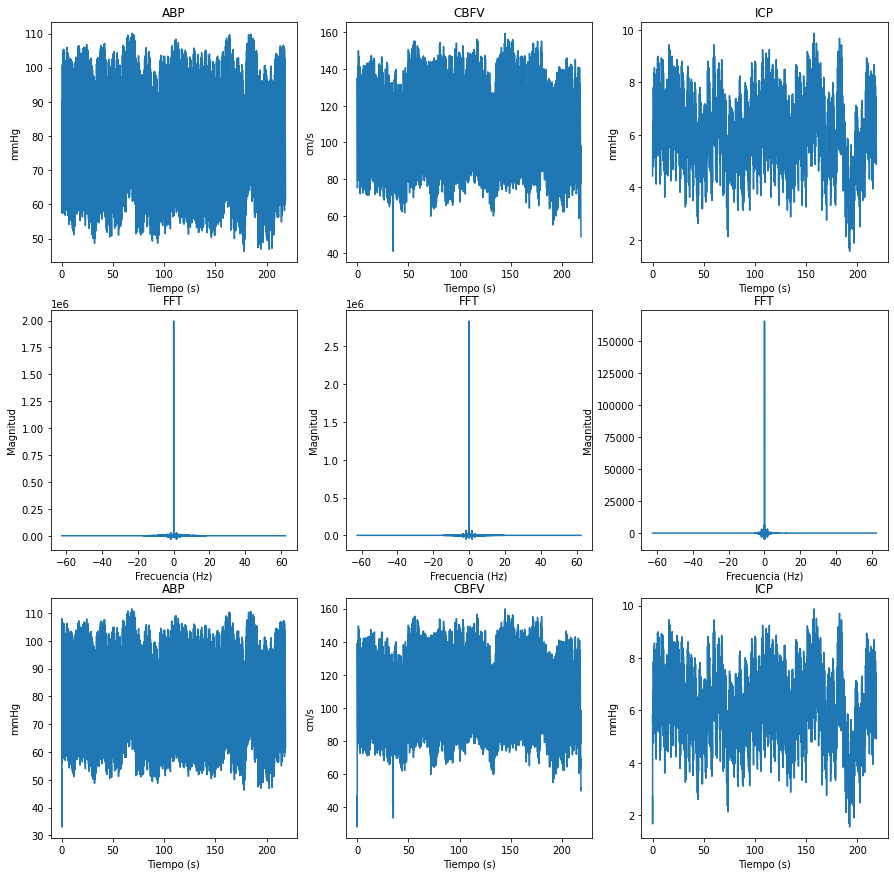

In [88]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np


segm_dict = {"ABP":[],"CBFV": [] ,"ICP":[]}

for i, record_name in enumerate(names):
    path = './dataset/waves/'
    record = wfdb.rdrecord(record_name=path+record_name)
    """
    if i==11:
        break
    """
    signal = record.p_signal
    cont = record.__dict__
    titles = cont["sig_name"]
    sig = cont["p_signal"]
    fs = cont["fs"]
    units = cont["units"]
    adc_gain = cont["adc_gain"]
    sig_l = cont["sig_len"]

    adj_sig = sig
    sig_dict = {titles[i]:adj_sig[:,i] for i in range(0,3)}
    units_dict = {titles[i]:units[i] for i in range(0,3)}

    filt_dict = {}
    for key, value in sig_dict.items():
        sig = value
        filt_sig,_,_ = butter_bandpass_filter(sig, 0.5, 14.0, fs, order=6)
        filt_sig,_,_ = butter_bandpass_filter(sig, 20.0, 25.0, fs, order=6, filter_tp = 'stop')
        filt_dict[key] = filt_sig

    fft_dict = {}
    for key, value in filt_dict.items():
        sig = value
        X,f,w = fft(sig, fs)
        fft_dict[key] = X
    t_seg = 5
    N_seg = 5*fs

    for key, value in filt_dict.items():
        point = N_seg
        while point + N_seg < len(value):
            segm = value[point:point+N_seg]
            segm_dict[key].append(segm)
            point += N_seg
    
print(len(segm_dict["ABP"]))
print(len(segm_dict["ICP"]))
print(len(segm_dict["CBFV"]))

t = np.arange(0, sig_l/fs, 1/fs)
plt.figure(figsize=(15, 15))
plt.subplot(331)
plt.plot(t, sig_dict["ABP"])#;plt.xlim([10, 20])
plt.title("ABP");plt.ylabel(units_dict["ABP"]);plt.xlabel("Tiempo (s)")
plt.subplot(332)
plt.plot(t, sig_dict["CBFV"])#;plt.xlim([10, 20])
plt.title("CBFV");plt.ylabel(units_dict["CBFV"]);plt.xlabel("Tiempo (s)")
plt.subplot(333)
plt.plot(t, sig_dict["ICP"])#;plt.xlim([10, 20])
plt.title("ICP");plt.ylabel(units_dict["ICP"]);plt.xlabel("Tiempo (s)")

plt.subplot(334)
plt.plot(f, fft_dict["ABP"])
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")
plt.subplot(335)
plt.plot(f, fft_dict["CBFV"])
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")
plt.subplot(336)
plt.plot(f, fft_dict["ICP"])
plt.title("FFT");plt.ylabel("Magnitud");plt.xlabel("Frecuencia (Hz)")

plt.subplot(337)
plt.plot(t, filt_dict["ABP"])#;plt.xlim([10, 20])
plt.title("ABP");plt.ylabel(units_dict["ABP"]);plt.xlabel("Tiempo (s)")
plt.subplot(338)
plt.plot(t, filt_dict["CBFV"])#;plt.xlim([10, 20])
plt.title("CBFV");plt.ylabel(units_dict["CBFV"]);plt.xlabel("Tiempo (s)")
plt.subplot(339)
plt.plot(t, filt_dict["ICP"])#;plt.xlim([10, 20])
plt.title("ICP");plt.ylabel(units_dict["ICP"]);plt.xlabel("Tiempo (s)")



### Extracción de características
Se extrajeron características de tiempo y frecuencia de las señales de ABP, CBFV e ICP. Estas características incluyen la media, desviación estándar, amplitud, frecuencia dominante y potencia de la señal. Además, se utilizaron técnicas de análisis de dominio de frecuencia, como la Transformada Rápida de Fourier (FFT), y técnicas de descomposición de wavelet para capturar información subyacente en las señales. Cada segmento se caracterizó utilizando el conjunto de características extraídas, y se creó un dataframe que consolidaba las características de cada segmento de ABP y CBFV. Este dataframe se utilizó para crear un modelo predictivo del ICP, considerando las relaciones entre las características extraídas de ABP y CBFV.

In [91]:
from scipy.stats import kurtosis


def extract_features(signal, fs):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1] - peaks[0]) / len(signal) if peaks.size > 1 else 0
    power = np.sum(np.square(signal)) / len(signal)
    kurtosis_val = kurtosis(signal)
    coeffs = pywt.wavedec(signal, 'db4', level=5)
    wavelet = np.concatenate(coeffs)
    rms = np.sqrt(np.mean(signal**2))
    area = cumtrapz(signal, initial=0)[-1]
    f, P = welch(signal, fs=fs, window='hann', noverlap=0, nfft=256)
    area_freq = cumtrapz(P, f, initial=0)[-1]
    total_power = np.trapz(P, f)
    median_freq = f[np.where(np.cumsum(P) > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]

    features = {
        'media': mean,
        'desviacion_estandar': std,
        'amplitud': amplitude,
        'frecuencia_dominante': dominant_frequency,
        'potencia': power,
        'kurtosis': kurtosis_val,
        'rms': rms,
        'area': area,
        'min_value': np.min(signal),
        'max_value': np.max(signal),
        'area_freq': area_freq,
        'total_power': total_power,
        'median_freq': median_freq,
        'f_max': f_max,
    }
    return features

In [101]:

dataframes = []
for signal_type in ['ABP', 'ICP', 'CBFV']:
    # Lista para almacenar las características de cada segmento
    features_list = []
    # Extraer las características de cada segmento y almacenarlas en la lista
    for segment in segm_dict[signal_type]:
        features = extract_features(segment, fs=125)
        features_list.append(features)
    # Crear un DataFrame a partir de la lista de características
    df = pd.DataFrame(features_list)
    # Agregar un prefijo a las columnas del DataFrame para identificar el tipo de señal
    df = df.add_prefix(f'{signal_type}_')
    # Agregar el DataFrame a la lista
    dataframes.append(df)

# Concatenar todos los DataFrames para obtener un único DataFrame con todas las características
all_features_df = pd.concat(dataframes, axis=1)

# Mostrar las primeras filas del DataFrame resultante
all_features_df.head()

,ABP_media,ABP_desviacion_estandar,ABP_amplitud,ABP_frecuencia_dominante,ABP_potencia,ABP_kurtosis,ABP_rms,ABP_area,ABP_min_value,ABP_max_value,...,CBFV_potencia,CBFV_kurtosis,CBFV_rms,CBFV_area,CBFV_min_value,CBFV_max_value,CBFV_area_freq,CBFV_total_power,CBFV_median_freq,CBFV_f_max
0,66.641384,11.490724,41.191509,0,4573.110805,-0.732653,67.624780,41579.706283,51.247460,92.438969,...,5419.772792,-0.591529,73.619106,45539.388377,58.416044,100.340963,103.082489,103.082489,1.464844,1.464844
1,67.378961,11.442618,43.396668,0,4670.857826,-0.674359,68.343674,42036.470128,51.309134,94.705801,...,4863.423446,-0.451027,69.738250,43206.504424,53.294024,91.480309,76.491657,76.491657,1.464844,1.464844
2,67.687198,11.308102,42.445611,0,4709.429904,-0.479220,68.625286,42244.903575,52.422143,94.867754,...,4493.080148,-0.756046,67.030442,41508.721107,51.930298,91.102156,71.524231,71.524231,1.464844,1.464844
3,69.787074,12.080038,43.576012,0,5016.163021,-0.718562,70.824876,43551.610943,53.260290,96.836302,...,4609.897889,-0.949087,67.896229,42065.365305,51.899062,88.384547,63.225485,63.225485,1.464844,1.464844
4,70.764247,12.052009,44.466655,0,5152.829593,-0.346857,71.783212,44159.252744,54.970395,99.437050,...,4583.707867,-0.876140,67.703086,41961.854743,53.051526,86.246286,54.945855,54.945855,1.464844,1.464844


In [6]:
all_features_df.columns

Index(['ABP_media', 'ABP_desviacion_estandar', 'ABP_amplitud',
       'ABP_frecuencia_dominante', 'ABP_potencia', 'ABP_kurtosis', 'ABP_rms',
       'ABP_area', 'ABP_min_value', 'ABP_max_value', 'ABP_area_freq',
       'ABP_total_power', 'ABP_median_freq', 'ABP_f_max', 'ICP_media',
       'ICP_desviacion_estandar', 'ICP_amplitud', 'ICP_frecuencia_dominante',
       'ICP_potencia', 'ICP_kurtosis', 'ICP_rms', 'ICP_area', 'ICP_min_value',
       'ICP_max_value', 'ICP_area_freq', 'ICP_total_power', 'ICP_median_freq',
       'ICP_f_max', 'CBFV_media', 'CBFV_desviacion_estandar', 'CBFV_amplitud',
       'CBFV_frecuencia_dominante', 'CBFV_potencia', 'CBFV_kurtosis',
       'CBFV_rms', 'CBFV_area', 'CBFV_min_value', 'CBFV_max_value',
       'CBFV_area_freq', 'CBFV_total_power', 'CBFV_median_freq', 'CBFV_f_max'],
      dtype='object')

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

predictors = [col for col in all_features_df.columns if 'ABP_' in col or 'CBFV_' in col]

# La variable dependiente (objetivo) es 'ICP_media'
target = 'ICP_media'

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(all_features_df[predictors], all_features_df[target], test_size=0.2, random_state=42)


### Modelos de regresión

Se implementaron dos modelos de regresión, un modelo de regresión lineal múltiple y un modelo polinomial, para predecir el valor medio del ICP. Se utilizó la biblioteca sklearn de Python para entrenar y evaluar los modelos utilizando el dataframe estructurado. Se calcularon métricas de rendimiento, incluido el coeficiente de determinación R^2, para evaluar la precisión de los modelos. Además, se realizó una visualización de los resultados del modelo para una interpretación gráfica de la efectividad del modelo en la predicción del ICP usando el error MSE y MAE.

In [21]:
# Inicializamos y ajustamos el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predecimos sobre el conjunto de prueba
y_pred_linear = linear_model.predict(X_test)

# Calculamos el R^2 para la regresión lineal
r2_linear = r2_score(y_test, y_pred_linear)
print(f"R^2 para la regresión lineal: {r2_linear}")


R^2 para la regresión lineal: 0.41797880002026866


In [23]:
# Establecemos el grado del polinomio
degree = 2

# Creamos un modelo de regresión polinomial usando un pipeline
polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Entrenamos el modelo polinomial
polynomial_model.fit(X_train, y_train)

# Predecimos sobre el conjunto de prueba
y_pred_poly = polynomial_model.predict(X_test)

# Calculamos el R^2 para la regresión polinomial
r2_poly = r2_score(y_test, y_pred_poly)
print(f"R^2 para la regresión polinomial de grado {degree}: {r2_poly}")


R^2 para la regresión polinomial de grado 2: 0.6775074256471307


# Resultados
R^2 = 0.68

,MSE,MAE
Linear Regression,8.789902,2.247060
Polynomial Regression,4.870404,1.515902


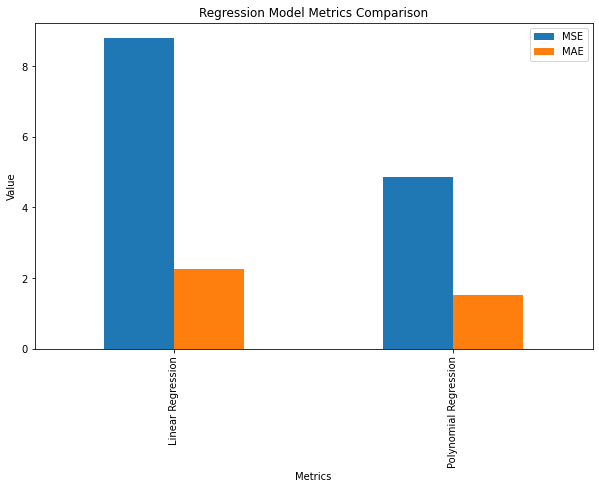

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate metrics for the linear regression model
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

# Calculate metrics for the polynomial regression model
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Linear Regression': [mse_linear, mae_linear],
    'Polynomial Regression': [mse_poly, mae_poly]
}, index=['MSE','MAE'])

# Visualize the metrics for comparison
metrics_plot = metrics_df.T.plot(kind='bar', figsize=(10, 6))
metrics_plot.set_title('Regression Model Metrics Comparison')
metrics_plot.set_ylabel('Value')
metrics_plot.set_xlabel('Metrics')
metrics_plot.figure.savefig('./regression_metrics_comparison.png')

metrics_df.T



# Discusiones

Los resultados obtenidos en el presente estudio reflejan avances significativos hacia el desarrollo de una metodología no invasiva y confiable para la estimación de la presión intracraneal (ICP) utilizando modelos de regresión basados en señales biomédicas periféricas. El modelo polinomial presentó un coeficiente de determinación R^2 de 0.68, superando al modelo de regresión lineal, lo que indica una capacidad razonable para predecir la ICP basándose en las características derivadas de la presión arterial (ABP) y la velocidad del flujo sanguíneo cerebral (CBFV). Adicionalmente, la reducción en los valores de Error Cuadrático Medio (MSE) y Error Absoluto Medio (MAE) en la regresión polinomial, con valores de 4.87 y 1.51 respectivamente, sugiere una mayor precisión y fiabilidad en la estimación de la ICP en comparación con el modelo lineal.

Es de destacar que la monitorización precisa de la ICP es una herramienta clínica esencial, particularmente en pediatría, donde la variabilidad fisiológica y las respuestas individuales a las patologías pueden complicar las mediciones invasivas (Imaduddin et al., 2020). La integración de un enfoque no invasivo continuo y en tiempo real, como el propuesto en este estudio, puede ayudar a superar estas barreras, minimizando los riesgos asociados con los métodos invasivos y proporcionando una herramienta de monitoreo más accesible y segura para la población pediátrica.

Sin embargo, cabe señalar que a pesar ello, un R^2 de 0.68 implica que aún queda una cantidad considerable de varianza no explicada en la predicción de la ICP. La inclusión de más características de señales o la aplicación de métodos de aprendizaje automático más avanzados podrían mejorar aún más la precisión del modelo.

# Conclusiones

Se demuestra el potencial de las técnicas no invasivas para la estimación de la ICP mediante el uso de regresiones múltiples. Los modelos desarrollados ofrecen una alternativa prometedora a las mediciones invasivas, especialmente en entornos clínicos pediátricos donde la seguridad del paciente es de máxima prioridad. El modelo polinomial, en particular, muestra una mejora significativa sobre el modelo lineal, lo que lo posiciona como un candidato preferible para la estimación de la ICP. No obstante, se reconocen las limitaciones del modelo actual y se recomienda continuar la investigación.

# Referencias

Fanelli, A., Vonberg, F. W., LaRovere, K. L., Walsh, B. K., Smith, E. R., Robinson, S., Tasker, R. C., & Heldt, T. (2019). Fully automated, real-time, calibration-free, continuous noninvasive estimation of intracranial pressure in children. Journal of Neurosurgery: Pediatrics, 24(5), 509–519. https://doi.org/10.3171/2019.5.peds19178

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

Heldt, T., Fanelli, A., Tasker, R., Vonberg, F., & LaRovere, K. (2024). Neurocritical care waveform recordings in pediatric patients (version 1.0.0). PhysioNet. https://doi.org/10.13026/5kvn-pp29.

Imaduddin, S. M., Fanelli, A., Vonberg, F. W., Tasker, R. C., & Heldt, T. (2020). Pseudo-Bayesian Model-Based Noninvasive Intracranial Pressure Estimation and Tracking. IEEE Transactions on Biomedical Engineering, 67(6), 1604–1615. https://doi.org/10.1109/tbme.2019.2940929

